# Performs RFM (Recency, Frequency, Monetary) Customer Segmentation using K-Means with Snowpark, based on an online retail dataset from Kaggle

In [1]:
import pandas as pd
import numpy as np


## Read a table 

In [2]:
df = pd.read_csv('OnlineRetail.csv', sep=',', encoding='latin-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Exploratory Data Analysis

In [3]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


### Remove null values and invalid data

In [4]:
import pandas as pd

# Assuming 'df' is your DataFrame
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### Filter to United Kingdom, rest of the data might have weaker representation from the population

In [5]:
df = df[df["Country"] == 'United Kingdom']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Features Preparation

### Obtain the recency, frequency and monetary (RFM) features for segmentation

In [6]:
import pandas as pd

# Assuming 'df' is the DataFrame with the required data

# Step 1: Calculate 'NOW'
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])  # Convert to datetime object
df["NOW"] = df["InvoiceDate"].max()

# Step 2: Calculate 'RECENCY', 'FREQUENCY', and 'MONETARY'
df_tf = df.groupby("CustomerID").agg(
    max_InvoiceDate=("InvoiceDate", "max"),
    max_NOW=("NOW", "max"),
    Monetary=("Quantity", lambda x: (x * df.loc[x.index, "UnitPrice"]).sum()),
    Frequency=("InvoiceNo", "count")
)

df_tf["RECENCY"] = (df_tf["max_InvoiceDate"] - df_tf["max_NOW"]).dt.days
df_tf = df_tf.reset_index()[["CustomerID", "Frequency", "Monetary", "RECENCY"]]
df_tf.head()

,CustomerID,Frequency,Monetary,RECENCY
0,12346.0,1,77183.60,-326
1,12747.0,103,4196.01,-2
2,12748.0,4595,33719.73,-1
3,12749.0,199,4090.88,-4
4,12820.0,59,942.34,-3


### Removal of outliers. Method is to remove data outside of 99 percentile

In [7]:
import pandas as pd
import numpy as np

# Assuming 'df_tf' is the DataFrame with the required data

# Step 1: Calculate 99th percentile values
freq_99pc = np.percentile(df_tf["Frequency"], 99)
rec_99pc = np.percentile(df_tf["RECENCY"], 99)
mon_99pc = np.percentile(df_tf["Monetary"], 99)

# Step 2: Filter the DataFrame
df_tf = df_tf[(df_tf["Frequency"] < freq_99pc) &
              (df_tf["RECENCY"] < rec_99pc) &
              (df_tf["Monetary"] < mon_99pc)]


In [8]:
df_tf.head()

,CustomerID,Frequency,Monetary,RECENCY
1,12747.0,103,4196.01,-2
3,12749.0,199,4090.88,-4
4,12820.0,59,942.34,-3
5,12821.0,6,92.72,-214
6,12822.0,46,948.88,-71


### Visualize the distribution

C:\Users\cbimo\AppData\Local\Temp\ipykernel_14240\2235685707.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_pd = df_tf[df_tf["Frequency"] < freq_99pc][df_tf["RECENCY"] < rec_99pc][df_tf["Monetary"] < mon_99pc]


<Axes: xlabel='Monetary', ylabel='Count'>

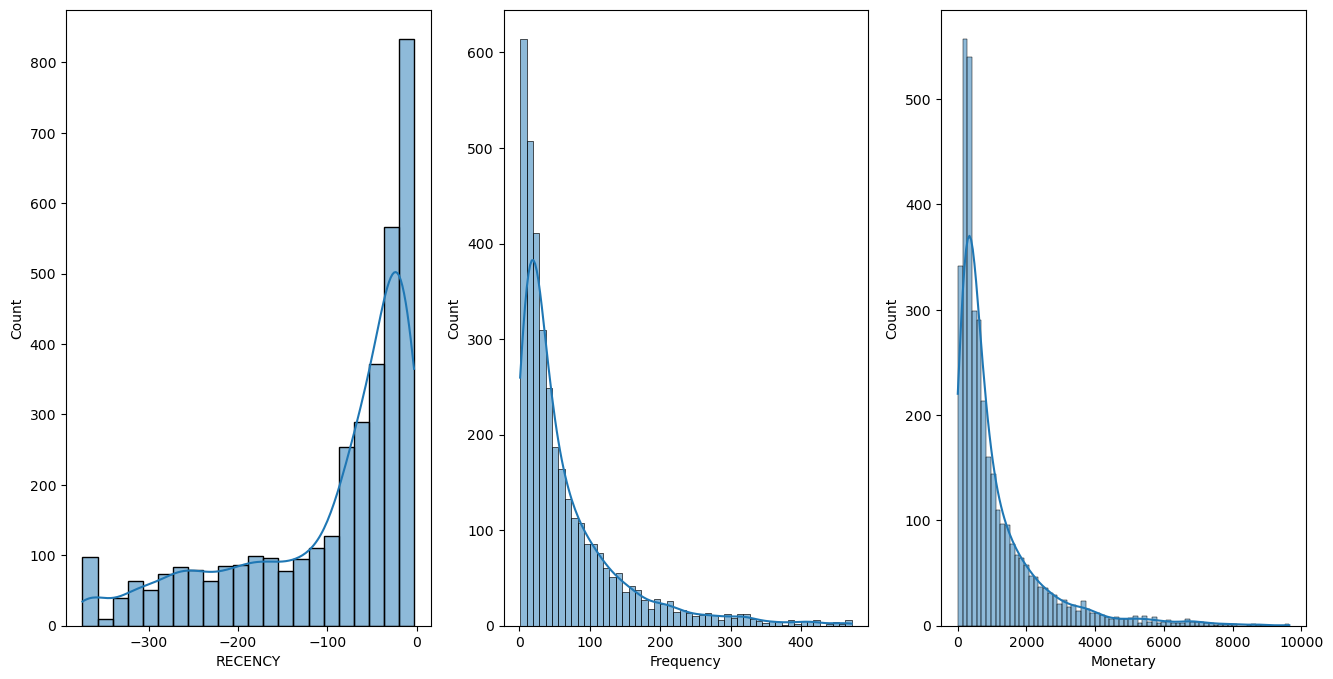

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 3, figsize=(16, 8))

# Assuming 'df_tf' is the DataFrame with the required data

# Step 1: Calculate 99th percentile values
freq_99pc = np.percentile(df_tf["Frequency"], 99)
rec_99pc = np.percentile(df_tf["RECENCY"], 99)
mon_99pc = np.percentile(df_tf["Monetary"], 99)

# Step 2: Filter the DataFrame and convert to pandas DataFrame
df_pd = df_tf[df_tf["Frequency"] < freq_99pc][df_tf["RECENCY"] < rec_99pc][df_tf["Monetary"] < mon_99pc]
df_pd = pd.DataFrame(df_pd)

# Recency distribution plot
sns.histplot(df_pd['RECENCY'], kde=True, ax=ax[0])

# Frequency distribution plot
sns.histplot(df_pd['Frequency'], kde=True, ax=ax[1])

# Monetary distribution plot
sns.histplot(df_pd['Monetary'], kde=True, ax=ax[2])


## Use K-Means clustering to segment your customers based on RFM as features. For this, create a stored procedure to perform training directly on Snowflake without moving data out.
### 1. Write the implementation code of the stored proc

[  65.84178777  -98.40170003 1079.01360954]
[[ 1.71827175  0.94260518  2.29151007]
 [-0.08828634  0.95259022 -0.10398501]
 [-0.77219761 -1.15425417 -0.75039907]
 ...
 [-0.75929363 -0.8247477  -0.75945291]
 [-0.6947737   0.902665   -0.68547768]
 [ 0.05365751  0.55318844  0.57690974]]


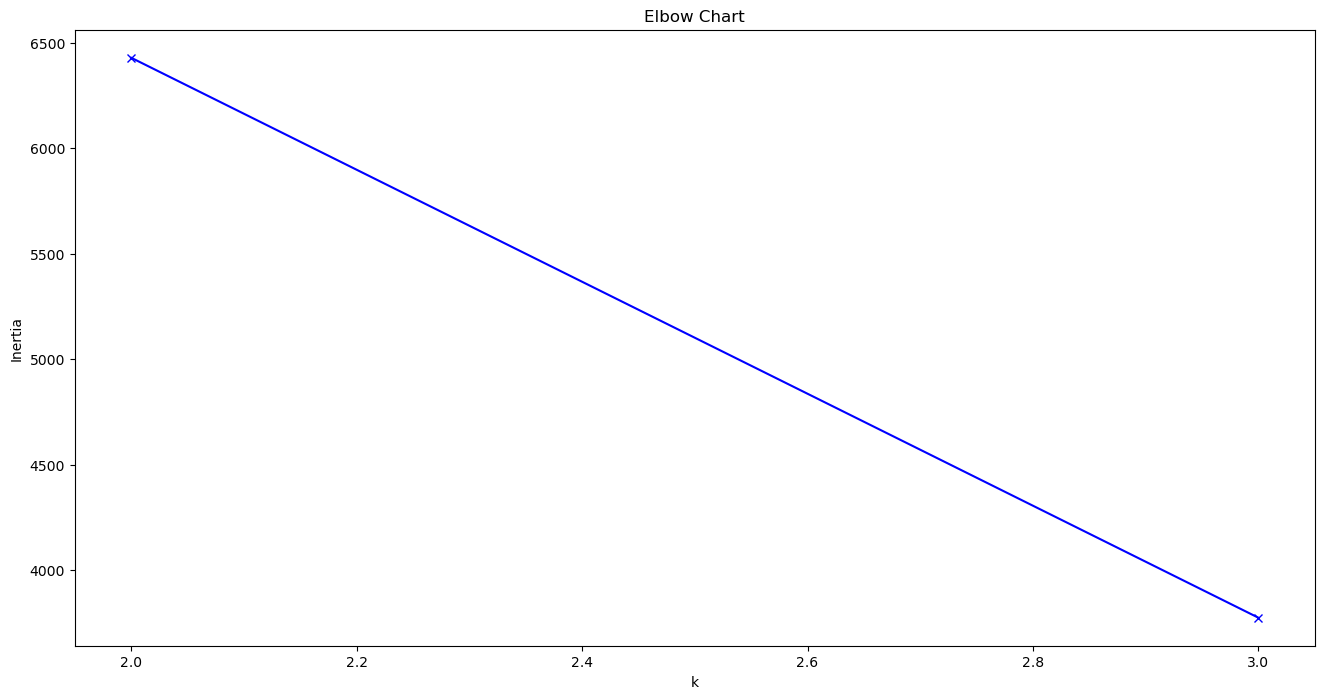

In [41]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Implementation code for the stored procedure
def kmeans_cluster(df_pd: pd.DataFrame, max_iter: int, iterate: int):
    scaler = StandardScaler()
    scaler.fit(df_pd[["Frequency", "RECENCY", "Monetary"]])
    print(scaler.mean_)
    df_train = scaler.transform(df_pd[["Frequency", "RECENCY", "Monetary"]])
    print(df_train)
    inertia = []

    if iterate == 1:
        K = range(2, max_iter)
        for k in K:
            model = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42).fit(df_train)
            inertia.append(model.inertia_)
        
        # Plot the elbow chart if iterate == 1
        plt.figure(figsize=(16, 8))
        plt.plot(K, inertia, 'bx-')
        plt.xlabel('k')
        plt.ylabel('Inertia')
        plt.title('Elbow Chart')
        plt.show()

    # Move the df_output.to_csv() outside of the else block
    df_pd['Cluster'] = KMeans(n_clusters=max_iter, init='k-means++', n_init=10, random_state=42).fit(df_train).labels_
    df_output = df_pd.copy()
    df_output.to_csv("RFM_Clusters.csv", index=False)  # Save the output to a CSV file

    return inertia

# Call the kmeans_cluster function
df_pd = df_pd  # Replace df_pd with the actual DataFrame you want to use
max_iter = 4
iterate = 1
results = kmeans_cluster(df_pd, max_iter, iterate)